## Команда "От заката до рассвета"

# Кейс 3 (УЦСБ) Обнаружение атак на завод по очистке воды

# Описание кейса

Вы можете попробовать применить машинное обучение для решения задачи информационной безопасности: обнаружение атак на киберфизические системы. Это системы для решения критически важных задач, которые состоят из физических компонентов и цифровых алгоритмов. 

Кейс подготовлен Сингапурским университетом c помощью стенда для безопасной очистки воды (Secure Water Treatment, SWaT), которая является уменьшенным вариантом реального завода. Стенд работал 11 дней, из которых 7 дней прошло в нормальном режиме (без атак и сбоев), а в оставшиеся дни проводились атаки двух типов:

<ul><li>Кибератаки через компьютерную сеть стенда.</li>
<li>Физические атаки, связанные с выводом из строя компонентов стенда (например, двигатель или насос).</li></ul>

Набор данных включает как состояние оборудования и характеристики очищаемой воды, так и сетевой трафик. Атаки в обучающем наборе данных размечены вручную. С помощью размеченных данных вам нужно научиться определять атаки для тестового набора данных.

Помогите сделать воду чистой и улучшить экологию!


In [1]:
pip install optuna

## Решение второй задачи

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, v_measure_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA

import optuna
from optuna.samplers import RandomSampler

In [3]:
#df = pd.read_excel('SWaT_Dataset_Attack_v0.xlsx', engine='openpyxl', header=1)

In [4]:
# чтение датасета
data = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1TPaBgFKxPhXCaVrdmHnb9wvoYcZESfBO', header = 1)

In [5]:
# Убрать пустые пространства из названия столбцов
data.columns = data.columns.str.replace(' ', '')

In [6]:
# Переведем данные столбца 'Timestamp' в формат времени
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

Создадим новый признак, время от начала эксперимента

In [7]:
begin = data.Timestamp[0]
data['time'] = data.Timestamp.apply(lambda x: x - begin)
data['time'] = data['time'].apply(lambda x: x.seconds)

In [8]:
# количественные признаки
num_cols = ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 
            'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 
            'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'time']

In [9]:
# Переименуем нашу целевую переменную
data = data.rename(columns={'Normal/Attack':'target'})

# Уберем пустые пространства в написании значения целевой переменной
data.target = data.target.apply(lambda x: 'Attack' if x == 'A ttack' else x)

# Заменим значения таргета на 0 и 1
data['target'].replace({'Normal':0, 'Attack':1}, inplace=True)

In [10]:
# Удалим колонку с датой
data_no_time = data.drop(columns=['Timestamp'])

Стандартизируем наши числовые признаки

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(data_no_time[num_cols])

Создаем окончательный датасет, с которым будем работать

In [12]:
data_no_time1 = data_no_time.drop(columns=num_cols)
data_scaler = np.hstack((X, data_no_time1))
data_scaler.shape

(449919, 53)

Для решения второй задачи воспользуемся кластеризацией и методом **KMeans**

С помощью метода локтя определим оптимальное количество кластеров

In [30]:
target = data.target

In [17]:
target_inv = target.apply(lambda x: 1 if x == 0 else 0)

In [13]:
inertia = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_scaler)
    inertia.append(np.sqrt(kmeans.inertia_))

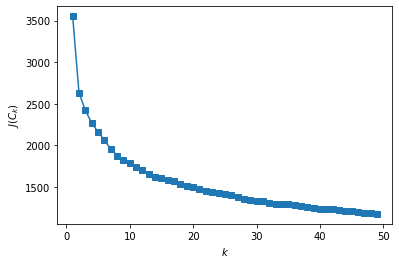

In [14]:
plt.plot(range(1, 50), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Как мы видим, на нашем датасете определить оптимальное количество кластеров не уаплось, график монотонно убывает

Так как классов у нас два, примем количество кластеров равным **двум** и решим задачу кластеризации

Применим фреймворк **Optuna** для подбора гиперпараметров модели, в качестве метрики выберем **accuracy**

In [15]:
def objective(trial):
    # Define the search space
    
    max_iter = trial.suggest_int('max_iter', 300, 3000, 100)
    n_init = trial.suggest_int('n_init', 10, 200, 10)
    algorithm = trial.suggest_categorical('algorithm', ['elkan', 'auto', 'full'])

    km = KMeans(n_clusters = 2,random_state=42, max_iter=max_iter, n_init=n_init, algorithm=algorithm)
    km.fit(data_scaler)
                                     
    score = accuracy_score(target_inv, km.labels_)

    return score

In [18]:
study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
study.optimize(objective, n_trials = 3)

[I 2022-05-20 19:47:05,032] A new study created in memory with name: no-name-2ecd4bde-7f45-4746-a212-989c6ed8e843
[I 2022-05-20 19:47:44,555] Trial 0 finished with value: 0.9495042440972709 and parameters: {'max_iter': 2000, 'n_init': 110, 'algorithm': 'auto'}. Best is trial 0 with value: 0.9495042440972709.
[I 2022-05-20 19:48:40,729] Trial 1 finished with value: 0.9495042440972709 and parameters: {'max_iter': 1200, 'n_init': 150, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.9495042440972709.
[I 2022-05-20 19:49:10,686] Trial 2 finished with value: 0.9495042440972709 and parameters: {'max_iter': 400, 'n_init': 80, 'algorithm': 'auto'}. Best is trial 0 with value: 0.9495042440972709.


Как мы видим, изменение гиперпараметров не приводит к изменению метрики

Создадим и обучим модель на выделение двух кластеров

In [19]:
km1 = KMeans(n_clusters = 2, random_state=42)
km1.fit(data_scaler);

In [20]:
km1.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

Как мы видим модель выдает нам метки инвертировано относительно нашей целевой переменной

Инвертируем нашу целевую переменную

In [21]:
# Считаем метрики нашей модели
print(f'F1: {f1_score(target_inv, km1.labels_)}')
print(f'Accuracy: {accuracy_score(target_inv, km1.labels_)}')
print(f'V мера: {v_measure_score(target_inv, km1.labels_)}')

F1: 0.9720610895424924
Accuracy: 0.9495042440972709
V мера: 0.551853520013453


Исходя из данных метрик, можно сделать вывод, что задача кластеризации у нас решилась плохо, а вот на задаче классификации модель показывает неплохие результаты

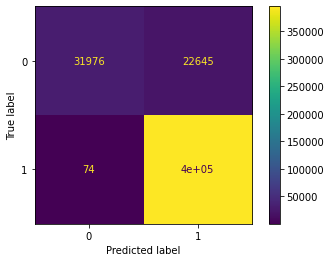

In [22]:
cm = confusion_matrix(target_inv, km1.labels_)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()

Модель плохо распознает атаки, 40% атак проходят незамеченными, но она практически не дает ложных тревог

Попробуем уменьшить датасет без потери качаства, для этого воспользуемся декомпозицией **методом главных компонент** с сохранением дисперсии на уровне 95% от исходного датасета

In [23]:
pca = PCA(n_components=0.95, random_state=42)

In [24]:
data_pca = pca.fit_transform(data_scaler)

In [25]:
data_pca.shape

(449919, 12)

Датасет уменьшился до 12 признаков

In [31]:
km2 = KMeans(n_clusters = 2,random_state=42)
km2.fit(data_pca);
print(f'F1: {f1_score(target, km2.labels_)}')
print(f'Accuracy: {accuracy_score(target, km2.labels_)}')
print(f'V мера: {v_measure_score(target, km2.labels_)}')

F1: 0.7378853609008676
Accuracy: 0.9495064667195651
V мера: 0.5518691601098523


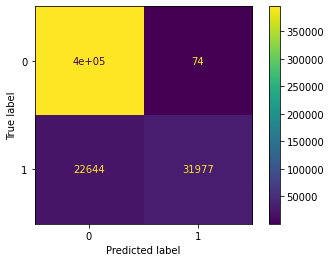

In [34]:
cm = confusion_matrix(target, km2.labels_)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()

При уменьшении размерности датасета, качество модели **не изменилось**

Попробуем уменьшить датасет до двух признаков, чтобы его можно было визуализировать

In [35]:
pca1 = PCA(n_components=2, random_state=42)

In [37]:
data_pca1 = pca1.fit_transform(data_scaler)
km3 = KMeans(n_clusters = 2,random_state=42)
km3.fit(data_pca);
print(f'F1: {f1_score(target, km3.labels_)}')
print(f'Accuracy: {accuracy_score(target, km3.labels_)}')
print(f'V мера: {v_measure_score(target, km3.labels_)}')

F1: 0.7378853609008676
Accuracy: 0.9495064667195651
V мера: 0.5518691601098523


Точность модели осталась прежней, это дает нам возможность анализировать работу установки с урезанными данными, как с полным датасетом

Посмотрим на кластеризацию модели

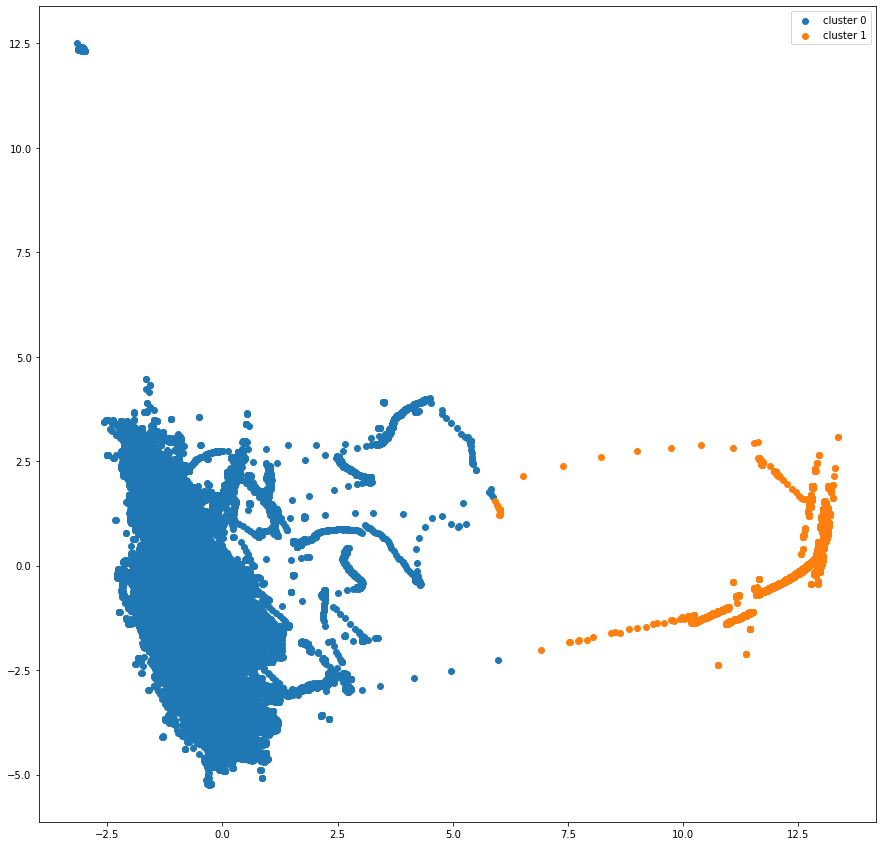

In [38]:
plt.figure(figsize=(15, 15))
plt.scatter(data_pca1[km3.labels_==0, 0], data_pca1[km3.labels_==0, 1], label='cluster 0')
plt.scatter(data_pca1[km3.labels_==1, 0], data_pca1[km3.labels_==1, 1], label='cluster 1')
plt.legend()

Анализируя данные кластеризации, можно предположить, что значения по оси X больше двух, распознанные как класс 0(Normal), принадлежат классу 1(Attack)

Попробуем разбить данные на большее число кластеров, например 5

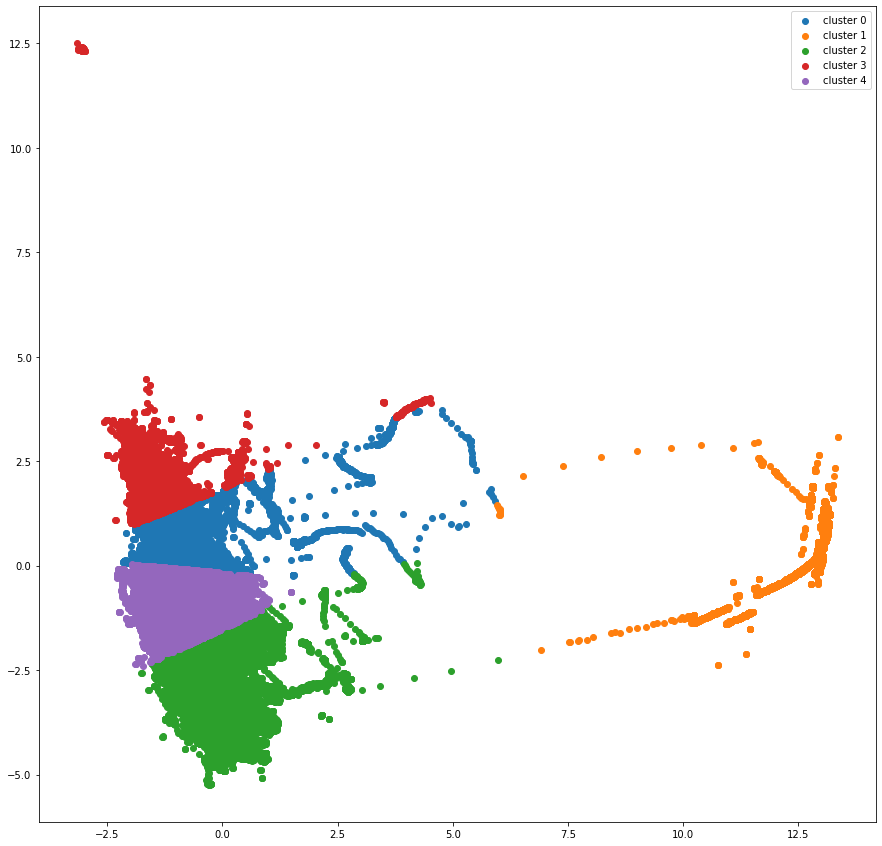

In [39]:
km4 = KMeans(n_clusters = 5,random_state=42)
km4.fit(data_pca1);
plt.figure(figsize=(15, 15))
plt.scatter(data_pca1[km4.labels_==0, 0], data_pca1[km4.labels_==0, 1], label='cluster 0')
plt.scatter(data_pca1[km4.labels_==1, 0], data_pca1[km4.labels_==1, 1], label='cluster 1')
plt.scatter(data_pca1[km4.labels_==2, 0], data_pca1[km4.labels_==2, 1], label='cluster 2')
plt.scatter(data_pca1[km4.labels_==3, 0], data_pca1[km4.labels_==3, 1], label='cluster 3')
plt.scatter(data_pca1[km4.labels_==4, 0], data_pca1[km4.labels_==4, 1], label='cluster 4')
plt.legend()

И вот тут мы сталкиваемся с ограничениями модели KMeans и собенностями ее кластеризации. Нам бы хотелось, чтобы модель разбивала данные по вертикали, а не горизониали.

Проверим гипотезу о принадлежности к кластерам ручной разметкой, значения по X меньше двух будем относить к классу 0, остальные к 1

In [41]:
dpca1 = pd.DataFrame(data_pca1)
labels = dpca1.iloc[:, 0].apply(lambda x: 0 if x<2 else 1)
print(f'F1: {f1_score(target, labels)}')
print(f'Accuracy: {accuracy_score(target, labels)}')
print(f'V мера: {v_measure_score(target, labels)}')

F1: 0.7691790568172905
Accuracy: 0.954211758116461
V мера: 0.579296853092406


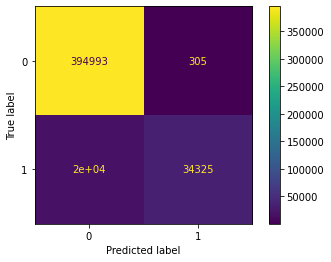

In [43]:
cm = confusion_matrix(target, labels)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()

Как видим модель стала работать немного лучше, все метрики выросли

А вот так выглядит разбиение на классы.

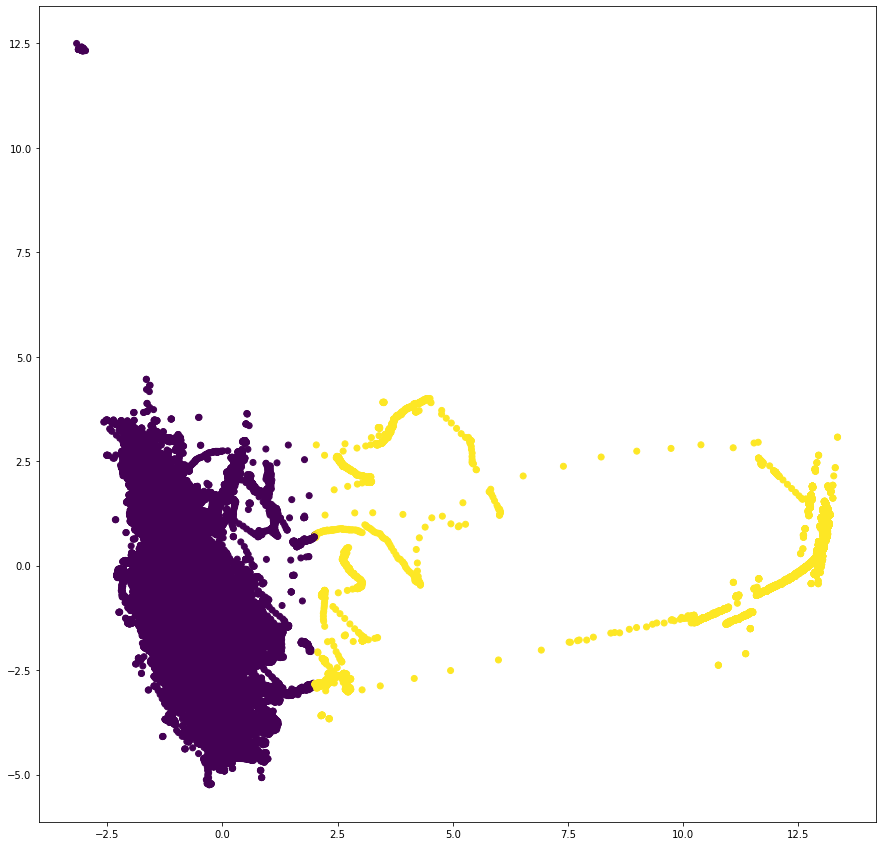

In [44]:
plt.figure(figsize=(15, 15))
plt.scatter(data_pca1[:, 0], data_pca1[:, 1], c=labels)

**Наша гипотеза подтвердилась.** Попробуем поработать с серединой распределения потоньше.

In [45]:
for i in range(len(data_pca1)):
    if data_pca1[i, 1] < 0:
        if data_pca1[i, 0] <2:
            labels[i] = 0
        else:
            labels[i] = 1
    elif data_pca1[i, 1] >=0:
        if data_pca[i, 0] <=0:
            labels[i] = 0
        else:
            labels[i] = 1
    

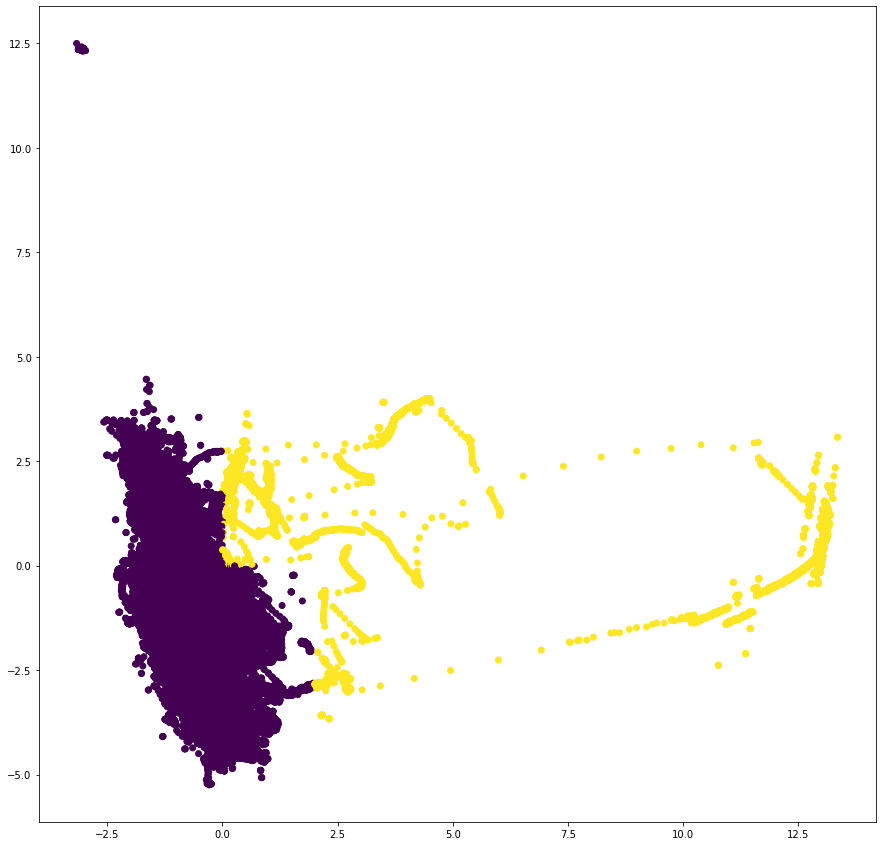

In [46]:
plt.figure(figsize=(15, 15))
plt.scatter(data_pca1[:, 0], data_pca1[:, 1], c=labels)

In [48]:
print(f'F1: {f1_score(target, labels)}')
print(f'Accuracy: {accuracy_score(target, labels)}')
print(f'V мера: {v_measure_score(target, labels)}')

F1: 0.7400209008931362
Accuracy: 0.9463659014178107
V мера: 0.4916343210222955


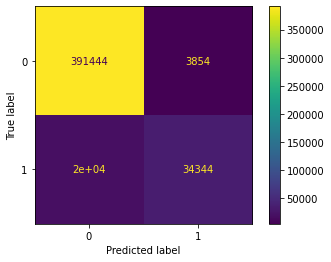

In [50]:
cm = confusion_matrix(target, labels)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()

Качество модели ухудшилось. Это говорит о том, что в "середине" классы перемешаны, и к их выделению надо подходить более избирательно.

Попробуем для этой сцели использовать **спектральную кластеризацию**.

In [ ]:
# spectral = SpectralClustering(n_clusters=2, random_state=42, n_jobs=-1)
# spectral.fit(data_pca1)

К сожалению нам это не удалось из-за ограниченности технических ресурсов, так же как и с использованием **DBSCAN**.

Разобьем датасет на большое количество кластеров, чтобы получить как можно более раздробленную "середину".

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


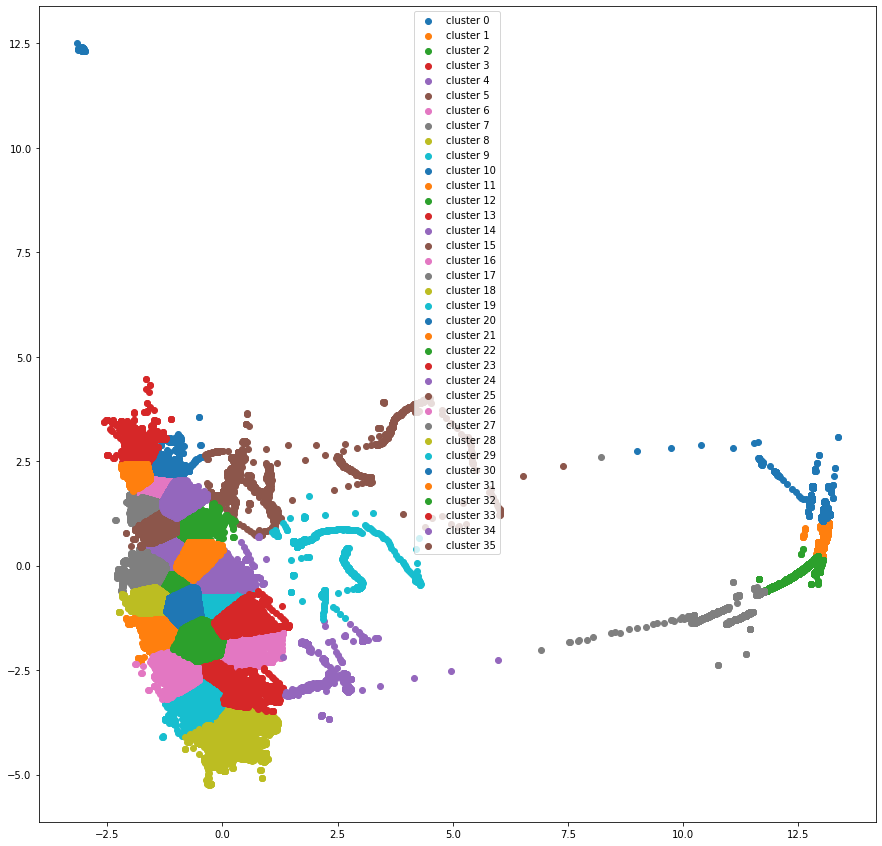

In [52]:
km5 = KMeans(n_clusters = 35,random_state=42)
km5.fit(data_pca1)
plt.figure(figsize=(15, 15))
plt.scatter(data_pca1[km5.labels_==0, 0], data_pca1[km5.labels_==0, 1], label='cluster 0')
plt.scatter(data_pca1[km5.labels_==1, 0], data_pca1[km5.labels_==1, 1], label='cluster 1')
plt.scatter(data_pca1[km5.labels_==2, 0], data_pca1[km5.labels_==2, 1], label='cluster 2')
plt.scatter(data_pca1[km5.labels_==3, 0], data_pca1[km5.labels_==3, 1], label='cluster 3')
plt.scatter(data_pca1[km5.labels_==4, 0], data_pca1[km5.labels_==4, 1], label='cluster 4')
plt.scatter(data_pca1[km5.labels_==5, 0], data_pca1[km5.labels_==5, 1], label='cluster 5')
plt.scatter(data_pca1[km5.labels_==6, 0], data_pca1[km5.labels_==6, 1], label='cluster 6')
plt.scatter(data_pca1[km5.labels_==7, 0], data_pca1[km5.labels_==7, 1], label='cluster 7')
plt.scatter(data_pca1[km5.labels_==8, 0], data_pca1[km5.labels_==8, 1], label='cluster 8')
plt.scatter(data_pca1[km5.labels_==9, 0], data_pca1[km5.labels_==9, 1], label='cluster 9')
plt.scatter(data_pca1[km5.labels_==10, 0], data_pca1[km5.labels_==10, 1], label='cluster 10')
plt.scatter(data_pca1[km5.labels_==11, 0], data_pca1[km5.labels_==11, 1], label='cluster 11')
plt.scatter(data_pca1[km5.labels_==12, 0], data_pca1[km5.labels_==12, 1], label='cluster 12')
plt.scatter(data_pca1[km5.labels_==13, 0], data_pca1[km5.labels_==13, 1], label='cluster 13')
plt.scatter(data_pca1[km5.labels_==14, 0], data_pca1[km5.labels_==14, 1], label='cluster 14')
plt.scatter(data_pca1[km5.labels_==15, 0], data_pca1[km5.labels_==15, 1], label='cluster 15')
plt.scatter(data_pca1[km5.labels_==16, 0], data_pca1[km5.labels_==16, 1], label='cluster 16')
plt.scatter(data_pca1[km5.labels_==17, 0], data_pca1[km5.labels_==17, 1], label='cluster 17')
plt.scatter(data_pca1[km5.labels_==18, 0], data_pca1[km5.labels_==18, 1], label='cluster 18')
plt.scatter(data_pca1[km5.labels_==19, 0], data_pca1[km5.labels_==19, 1], label='cluster 19')
plt.scatter(data_pca1[km5.labels_==20, 0], data_pca1[km5.labels_==20, 1], label='cluster 20')
plt.scatter(data_pca1[km5.labels_==21, 0], data_pca1[km5.labels_==21, 1], label='cluster 21')
plt.scatter(data_pca1[km5.labels_==22, 0], data_pca1[km5.labels_==22, 1], label='cluster 22')
plt.scatter(data_pca1[km5.labels_==23, 0], data_pca1[km5.labels_==23, 1], label='cluster 23')
plt.scatter(data_pca1[km5.labels_==24, 0], data_pca1[km5.labels_==24, 1], label='cluster 24')
plt.scatter(data_pca1[km5.labels_==25, 0], data_pca1[km5.labels_==25, 1], label='cluster 25')
plt.scatter(data_pca1[km5.labels_==26, 0], data_pca1[km5.labels_==26, 1], label='cluster 26')
plt.scatter(data_pca1[km5.labels_==27, 0], data_pca1[km5.labels_==27, 1], label='cluster 27')
plt.scatter(data_pca1[km5.labels_==28, 0], data_pca1[km5.labels_==28, 1], label='cluster 28')
plt.scatter(data_pca1[km5.labels_==29, 0], data_pca1[km5.labels_==29, 1], label='cluster 29')
plt.scatter(data_pca1[km5.labels_==30, 0], data_pca1[km5.labels_==30, 1], label='cluster 30')
plt.scatter(data_pca1[km5.labels_==31, 0], data_pca1[km5.labels_==31, 1], label='cluster 31')
plt.scatter(data_pca1[km5.labels_==32, 0], data_pca1[km5.labels_==32, 1], label='cluster 32')
plt.scatter(data_pca1[km5.labels_==33, 0], data_pca1[km5.labels_==33, 1], label='cluster 33')
plt.scatter(data_pca1[km5.labels_==34, 0], data_pca1[km5.labels_==34, 1], label='cluster 34')
plt.scatter(data_pca1[km5.labels_==35, 0], data_pca1[km5.labels_==35, 1], label='cluster 35')
plt.legend()

Середина получилась не очень раздробленной, но уже можно отдельным небольшим кластерам присваивать метки классов 0 или 1 и проверять качество модели по метрикам. В "идеале" можно было бы перебрать все возможные варианты и выбрать наилучшую модель. В данном случае количество вариантов будет 2**35.

In [53]:
2**35

34359738368

Можно в качестве оптимизации сделать выборку "середины" датасета и уже с ней отдельно поработать.

Отдельно хотелось бы упомянуть о таком инструменте, как пакет **Orion**. К сожалению из-за конфликта библиотек и ограниченности по времени не удалось его поюзать.

## Выводы:

<ul><li>Для решения задачи нами была использована <b>кластеризация</b>, которая неплохо справилась с ее решением и имеет право на жизнь</li>
    <li>В качестве модели был использован метод <b>KMeans</b>, который в силу своих ограничений не смог сразу справиться с задачей. 
        В качестве альтернативы можно предложить использовать <b>спектральную кластеризацию</b> или метод <b>DBSCAN</b>.</li>
    <li>Не смотря на это была получена метрика <b>accuracy=0.95</b>, хоть модель и не очень хорошо распознавала атаки.</li>
    <li>У данной модели есть потенциал для роста точности, если более избирательно подойти к оценке достаточно большого количества кластеров.</li>